In [1]:
import matplotlib.pyplot as plt
import numpy as np


# duration is the 5th element, 0 -> 4.
def get_heart_rate(file_name):
    csv_data = np.loadtxt(file_name, delimiter=',', skiprows=3, dtype=str)
    x = csv_data[:, 1]
    y = csv_data[:, 2]
    y = y.astype(int)
    # print(y)
    time_line = [i for i in range(len(x))]
    plt.figure()
    #plt.ylim(50, 200)
    plt.plot(time_line, y, linestyle='-', color='r')

    plt.title(file_name)
    plt.xlabel('time line')
    plt.ylabel('heart rate')
    plt.show()
    return y



# Auto generated log json file might misses square brackets, and cause a file reading error. Add '[ ]', and delete the last ','.

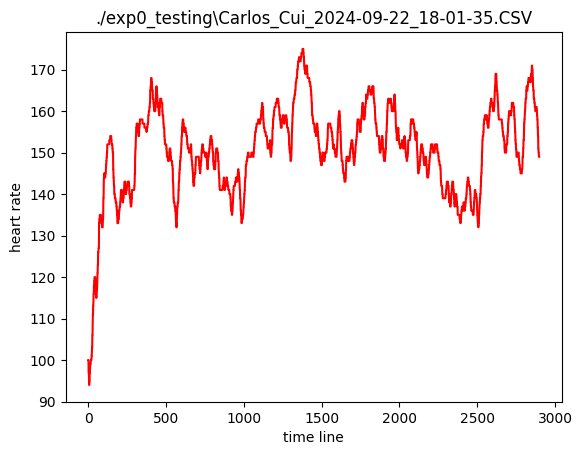

In [2]:
# open the expirment folder: auto
import glob
import json
ob_generate_time = './exp0_testing/log_Cube*.json'
ob_file = glob.glob(ob_generate_time)[0]
obstacle_time = json.load(open(ob_file))

control_xx = './exp0_testing/log_Control*.json'
control_file = glob.glob(control_xx)[0]
control_time = json.load(open(control_file))

# heart rate from polar. Sam.
heart_r = './exp0_testing/*.csv'
heart_r_file = glob.glob(heart_r)[0]
heart_rate_line = get_heart_rate(heart_r_file)

pupil_xx = './exp0_testing/log_eye*.json'
pupil_size_file = glob.glob(pupil_xx)[0]



In [3]:
# {"Time":36.74888229370117}
original_time_reaction_time = []
for o_s in obstacle_time:
    event_start_time = o_s["Time"]
    a_l = [x for x in control_time if event_start_time <= x['time'] <= event_start_time + 3]
    # if driver didn't react within 3 second, discard the reaction time. Don't have to dodge or dont want to dodge?\
    brake_time = [0]

    if a_l[0]["BrakePercentage"] == 0:
        # when user didn't decelerate, RT is when they decelerate
        for i in a_l:
            if i['BrakePercentage'] != 0:
                brake_time.append(i['time'] - event_start_time)
                break
    
    steer_time = [0]
    start_angle = a_l[0]["SteerPercentage"]
    for i in a_l:
        # can change
        if abs(start_angle - i["SteerPercentage"]) >= 0.5:
            # use steer to dodge
            steer_time.append(i['time'] - event_start_time)
            break
    
    if sum(steer_time) == 0:
        # no steer reaction
        min_reaction_time = sum(brake_time)
    elif sum(brake_time) == 0:
        min_reaction_time = sum(steer_time)
    else:
        min_reaction_time = min(sum(steer_time), sum(brake_time))
    if  min_reaction_time != 0: # 0 is didn't react in 3 second, might be error.
        original_time_reaction_time.append((event_start_time, min_reaction_time))
    else:
        pass
        # discard the RT if didn't react

# This part is related to the data analsys part... don't have to change.
events_reaction_time = {x[0]:x[1] for x in original_time_reaction_time}
events =[x[0] for x in original_time_reaction_time]
reactions_time = [x[1] for x in original_time_reaction_time]
reacted_time = [x[0] + x[1] for x in original_time_reaction_time]
# This part is related to the data analsys part... don't have to change.
print('Event time and reaction times: ', original_time_reaction_time)

Event time and reaction times:  [(26.721073150634766, 0.8389263153076172), (28.607107162475586, 0.19289207458496094), (36.74888229370117, 0.5111160278320312)]


In [4]:
import xml.etree.ElementTree as ET
def read_game_log(file_name):
    # list of tuple (event_time, reaction_time)
    events_time_line = []
    reacted_time = []
    tree = ET.parse(file_name)
    events = tree.getroot()
    for time in events.iter('time'):
        events_time_line.append(float(time.text))
    
    for reat in events.iter('react'):
        reacted_time.append(float(reat.text))

    events_reaction = {}
    reactions_time = []
    for i in range(len(events_time_line)):
        start = events_time_line[i]
        end = reacted_time[i]
        reaction_time = end - start
        events_reaction[start] = reaction_time
        reactions_time.append(reaction_time)
    #print(events_reaction)
    
    return events_reaction, events_time_line, reactions_time, reacted_time

# events_reaction_time, events, reactions_time, reacted_time = read_game_log('game_log.xml')
# events_reaction_time = 

In [5]:
#print(events_reaction_time)


In [6]:
heart_rate_5 = []
def heart_blocks(heart_rate_line, events,interval = 5):
    time_heart_rate_dict = {}
    for i in events:
        time_heart_rate_dict[i] = heart_rate_line[round(i): round(i)+interval+1]
    return time_heart_rate_dict

blocks_dict = heart_blocks(heart_rate_line, events, 10)

### Need to convert heart rate in second to RR interval in order to calculate the HRV. The formula is RR = 60,000/ heart rate. (The unit of rr is ms) <br> And the HRV can be found in std function <br> !!!! The larger the interval, the larger the HRV!!!!

In [7]:
hrv_list = []
for event, block in blocks_dict.items():
    rr_interval = [60000/heart_rate_s for heart_rate_s in block]
    HRV = np.std(rr_interval)
    hrv_list.append(HRV)
    print(f'Event happened at {event}s. The heart rates are: {block}. The HRV is {HRV :.5} ms. The reaction time is: {events_reaction_time[event]}.')

Event happened at 26.721073150634766s. The heart rates are: [106 109 111 111 113 113 115 116 116 118 118]. The HRV is 17.218 ms. The reaction time is: 0.8389263153076172.
Event happened at 28.607107162475586s. The heart rates are: [111 111 113 113 115 116 116 118 118 119 119]. The HRV is 13.024 ms. The reaction time is: 0.19289207458496094.
Event happened at 36.74888229370117s. The heart rates are: [118 119 119 120 120 120 120 120 118 118 117]. The HRV is 4.4447 ms. The reaction time is: 0.5111160278320312.


## Analysis of HRV vs Reaction time

if p > 0.05 we can't reject the null hypothesis, means no relationship between two variables.
Pearson correlation: 0.3302103573468159, p-value: 0.7857606242327905
There is no linear relationship between HRV and Reaction Time
Spearman correlation: 0.5, p-value: 0.6666666666666667
There is no non-linear relationship between HRV and Reaction Time


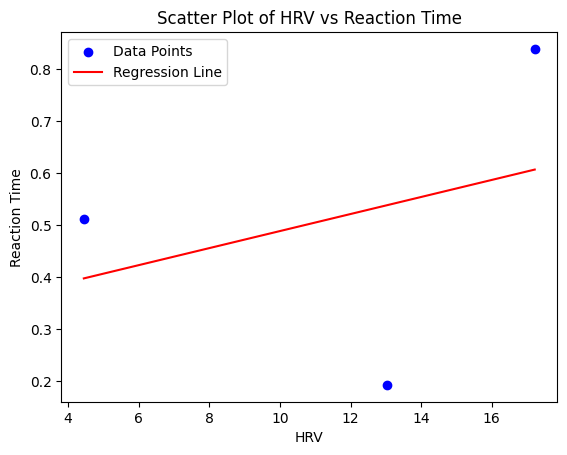

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

print("if p > 0.05 we can't reject the null hypothesis, means no relationship between two variables.")
# pearsonr test to test whether HRV and Reaction_time has relationship.
corr, p_value = pearsonr(hrv_list, reactions_time)
# get the linear relationship between two datasets
print(f'Pearson correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no linear relationship between HRV and Reaction Time")
else:
    print("There has linear relationship between HRV and Reaction Time")

corr, p_value = spearmanr(hrv_list, reactions_time)
# get the non-linear relationship between two datasets
print(f'Spearman correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no non-linear relationship between HRV and Reaction Time")
else:
    print("There has non-linear relationship between HRV and Reaction Time")


plt.scatter(hrv_list, reactions_time, label='Data Points', color='blue')
plt.xlabel('HRV')
plt.ylabel('Reaction Time')
plt.title('Scatter Plot of HRV vs Reaction Time')


slope, intercept = np.polyfit(hrv_list, reactions_time, 1)
x_fit = np.linspace(min(hrv_list), max(hrv_list), 100)
y_fit = slope * x_fit + intercept

# draw a regression line
plt.plot(x_fit, y_fit, color='red', label='Regression Line')
plt.legend()
plt.show()




In [9]:
# linear regression
import statsmodels.api as sm
X = sm.add_constant(hrv_list)  # Add a constant for the intercept
model = sm.OLS(reactions_time, X).fit()
print(model.summary())
# check the P value on the real dataset.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                 -0.782
Method:                 Least Squares   F-statistic:                    0.1224
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.786
Time:                        10:04:01   Log-Likelihood:              -0.085396
No. Observations:                   3   AIC:                             4.171
Df Residuals:                       1   BIC:                             2.368
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3249      0.596      0.545      0.6

c:\Users\10138\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## Analysis of Pupil diameter vs Reaction time

In [10]:
import json
file = open(pupil_size_file, 'r') 
data = json.load(file)
file.close()
time_pl_pr = [list(entry.values()) for entry in data]
time_pl_pr = np.array(time_pl_pr)
# no -1, -1
time_pl_pr = time_pl_pr[(time_pl_pr[:, 1] != -1) & (time_pl_pr[:, 2] != -1)]
#print(time_pl_pr)
def get_pupil_variance(event_time, end_time, data):
    list_within_event_react = data[(event_time<=data[:, 0]) & (data[:, 0]<=end_time)]
    #print(list_within_event_react)
    avg_p_size = [(x[1] + x[2])/2 for x in list_within_event_react]
    return (np.std(avg_p_size))
     

# get_pupil_variance(1, 2, time_pl_pr)
# get_pupil_variance(2, 3, time_pl_pr)
# print(events)
# print(reacted_time)
pupil_stds = []
for i in range(len(events)):
    pupil_stds.append(get_pupil_variance(events[i], reacted_time[i], time_pl_pr))
print(pupil_stds)
    

[26.721073150634766, 28.607107162475586, 36.74888229370117]
[27.559999465942383, 28.799999237060547, 37.2599983215332]
[np.float64(0.03708732057170841), np.float64(0.04184723336128909), np.float64(0.07155458068284491)]


Pearson correlation: -0.13591356951422404, p-value: 0.9132061056200739
There is no linear relationship between Pupil diameter std and Reaction Time
Spearman correlation: 0.5, p-value: 0.6666666666666667
There is no non-linear relationship between Pupil diameter std and Reaction Time


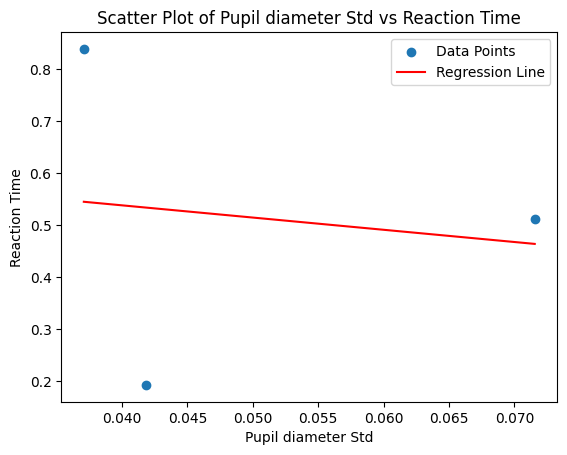

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


corr, p_value = pearsonr(pupil_stds, reactions_time)
print(f'Pearson correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no linear relationship between Pupil diameter std and Reaction Time")
else:
    print("There has linear relationship between Pupil diameter std and Reaction Time")

corr, p_value = spearmanr(hrv_list, reactions_time)
print(f'Spearman correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no non-linear relationship between Pupil diameter std and Reaction Time")
else:
    print("There has non-linear relationship between Pupil diameter std and Reaction Time")

plt.scatter(pupil_stds, reactions_time, label='Data Points')
plt.xlabel('Pupil diameter Std')
plt.ylabel('Reaction Time')
plt.title('Scatter Plot of Pupil diameter Std vs Reaction Time')

slope, intercept = np.polyfit(pupil_stds, reactions_time, 1)
x_fit = np.linspace(min(pupil_stds), max(pupil_stds), 100)
#print(slope)
y_fit = slope * x_fit + intercept

plt.plot(x_fit, y_fit, color='red', label='Regression Line')
plt.legend()
plt.show()


In [12]:
X = sm.add_constant(pupil_stds) 
model = sm.OLS(reactions_time, X).fit()
print(model.summary())
# check the P value on the real dataset.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.963
Method:                 Least Squares   F-statistic:                   0.01882
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.913
Time:                        10:04:02   Log-Likelihood:               -0.23061
No. Observations:                   3   AIC:                             4.461
Df Residuals:                       1   BIC:                             2.658
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6322      0.898      0.704      0.6

c:\Users\10138\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
